In [0]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import seaborn as sns 
sns.set()
%matplotlib inline
from datetime import datetime
from datetime import timedelta

In [0]:
# loading data 
from google.colab import files  
uploaded = files.upload() 

Saving co2_level_weekly.csv to co2_level_weekly.csv


In [0]:
# pre-processing of the data  
# deleting all citation information in data (see citation in write up)
data = pd.read_csv('co2_level_weekly.csv', names=['date', 'level'],skiprows=44,header=None)

# converting the date column to number of days since the start 
def days_from_start(start,current):
    start = datetime.strptime(start, "%Y-%m-%d")
    current = datetime.strptime(current, "%Y-%m-%d")  
    return int((current-start).days) # returns count of days 

# creating an array that will represent days since the first weekly measurement 
time = [] # storage for the count of days  
for i in range(0,len(data.date)): 
    first = data.date[0] # start at 0 
    time.append(days_from_start(first, data.date[i])) # appending 
last_day = time[3138] 
for i in range(1,2081): # we add 2080 spaces in the array to represent measurement counts every week 
    time.append(last_day + 7*(i)) 

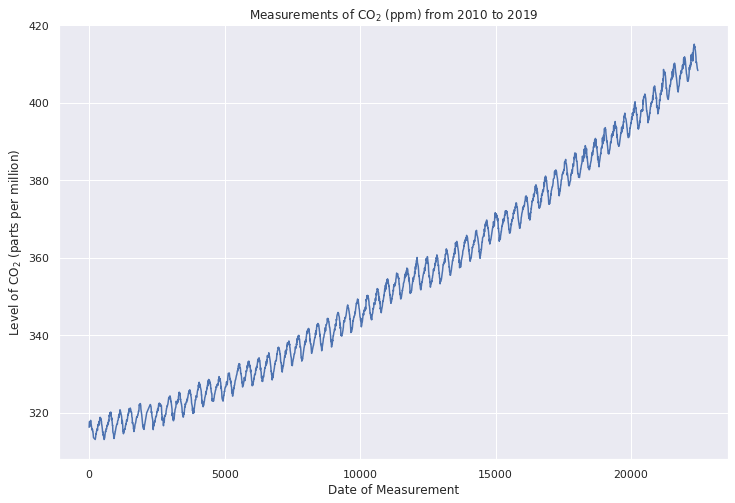

In [0]:
# visualization as in assignment prompt
# trend, seasonal variation, and noise can be observed
plt.figure(figsize = (12,8))
plt.plot(time[0:3139], data['level'])
plt.xlabel('Date of Measurement')
plt.ylabel(r'Level of CO$_2$ (parts per million)')
plt.title(r'Measurements of CO$_2$ (ppm) from 2010 to 2019')
plt.show()

In [0]:
# CO2 data to be incorporated into stan model 
model_data = {
    'N': len(data), # length of the data 
    'pred_N': len(time),
    'co2_level': data['level'], # dependent var 
    't': time} # time variable measured by data since original measurement

In [0]:
stan_code = """
data {
  int<lower=0> N;  // number of data points collected 
  real<lower=0> co2_level[N]; // data values for CO2 levels
  int<lower=0> pred_N;
  real<lower=0> t[pred_N]; // data for time since first measure 
}

parameters {
  real<lower=0> c_0; // 
  real<lower=0> c_1; // 
  real<lower=0> c_2; //
  real<lower=0> c_3; // 
  real<lower=0> c_4; // random noise

}

model {
  // Priors
  c_0 ~ normal(300, 30);
  c_1 ~ normal(0, 10);
  c_2 ~ normal(0, 10);
  c_3 ~ normal(0, 10);
  c_4 ~ normal(0, 10);

  // Likelihood
  for(i in 1:N) {
    co2_level[i] ~ normal(c_0 + c_1*t[i] + c_2*sin(2*pi()*t[i]/365.25 + c_3), c_4^2);
    }
}
    // Generate the predicted function values for the next n_future steps.
generated quantities {
  real co2_pred[pred_N]; // store future values
  for(i in 1:pred_N) {
    co2_pred[i] = normal_rng(c_0 + c_1*t[i] + c_2*sin(2*pi()*t[i]/365.25 + c_3), c_4^2); 
    }}

"""

linear_stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d911038be7de44273173c71767d6032c NOW.


In [0]:
parameters = ['c_0', 'c_1', 'c_2', 'c_3', 'c_4']

#printing out and storing stan results
results = linear_stan_model.sampling(data=model_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_d911038be7de44273173c71767d6032c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0 306.09  2.1e-3   0.14 305.82  306.0 306.09 306.18 306.35   4141    1.0
c_1 4.3e-3  1.6e-7 1.0e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   4387    1.0
c_2   2.89  2.1e-3    0.1   2.71   2.83   2.89   2.96   3.08   2006    1.0
c_3   4.28    3.85   5.44   1.07   1.12   1.15   8.04  13.75      2 177.65
c_4   1.94  2.4e-4   0.01   1.91   1.93   1.94   1.94   1.96   2638    1.0

Samples were drawn using NUTS at Fri Dec 20 10:12:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Improved Model 

In [0]:
stan_data = {
    'N': len(data), # length of the data 
    'pred_N': len(time),
    'co2_level': data['level'], # dependent var 
    't': time} # time variable measured by data since original measurement

In [0]:
stan_code_improved = """
data {
  int<lower=0> N;  // number of data points collected 
  int<lower=0> pred_N; // predictions
  real<lower=0> co2_level[N]; // data values for CO2 levels & date
  real<lower=0> t[pred_N]; // days since first measurement  
}

parameters {
    real<lower=0> c_0; 
    real<lower=0> c_1; 
    real<lower=0> c_2; 
    real phi_x; // phase 
    real phi_y; // phase
    real<lower=0> c_4;
    real<lower=0> c_5;    

}

transformed parameters {
    real<lower=0> phi;
    phi = atan2(phi_x, phi_y) / (2 * pi()) + 0.5; // The atan2 function returns a value in the range [-pi, pi], which we
    // then transform linearly into the range [0, 1].
}

model {
    c_0 ~ normal(300, 30);
    c_1 ~ normal(0.01, 0.01); 
    c_2 ~ normal(0.01, 0.01);
    phi ~ normal(0,1);
    c_4 ~ normal(3,1);
    c_5 ~ normal(1,1);

    for(i in 1:N) {
        co2_level[i] ~ normal(c_0 + c_1*(t[i]) + c_2*(t[i])^2 + c_4*sin(2*pi()*t[i]/365.25 + phi), c_5);
    }
}

// Generate the predicted function values for the next n_future steps.

generated quantities {
    real CO2_pred[pred_N];
    for(i in 1:pred_N) {
        CO2_pred[i] = normal_rng(c_0 + c_1*(t[i]) + c_2*(t[i])^2 + c_4*sin(2*pi()*t[i]/365.25 + phi), c_5);}
}
"""
quad_stan_model = pystan.StanModel(model_code=stan_code_improved)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_acd1f8b3a8c1d2d9408d911823d6ee3a NOW.


In [0]:
parameters = ['c_0','c_1','c_2','phi','c_4','c_5']
#printing out and storing stan results
final_results = quad_stan_model.sampling(data=stan_data)
print(final_results.stansummary(pars=parameters))
improved_samples = final_results.extract()


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_acd1f8b3a8c1d2d9408d911823d6ee3a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0 314.54    0.02    0.06 314.45 314.49 314.54 314.59 314.67      6   1.26
c_1 2.1e-3  3.1e-6  1.1e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3     13   1.13
c_2 9.7e-8 4.8e-11 4.5e-10 9.6e-8 9.7e-8 9.7e-8 9.7e-8 9.8e-8     89   1.06
phi    1.0  4.1e-5  5.0e-4    1.0    1.0    1.0    1.0    1.0    153   1.03
c_4   2.83    0.02    0.03   2.78   2.81   2.83   2.87   2.88      4   1.51
c_5   1.03  8.0e-4    0.01   1.01   1.03   1.03   1.04   1.06    195   1.01

Samples were drawn using NUTS at Fri Dec 20 10:25:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


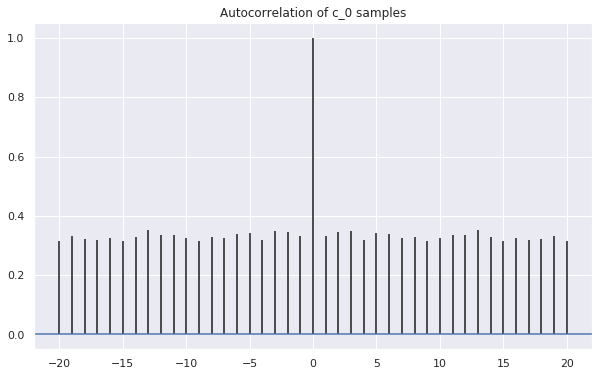

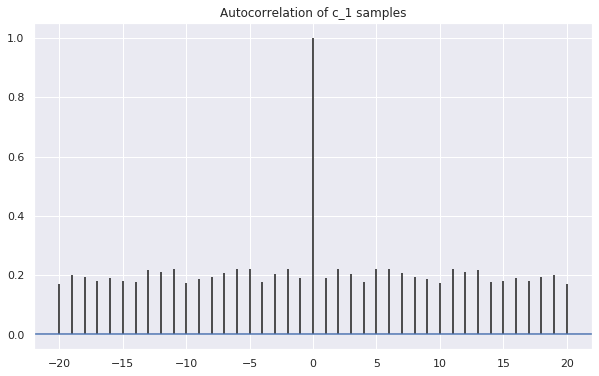

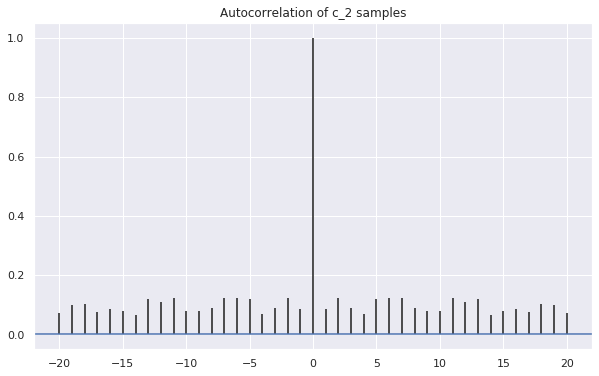

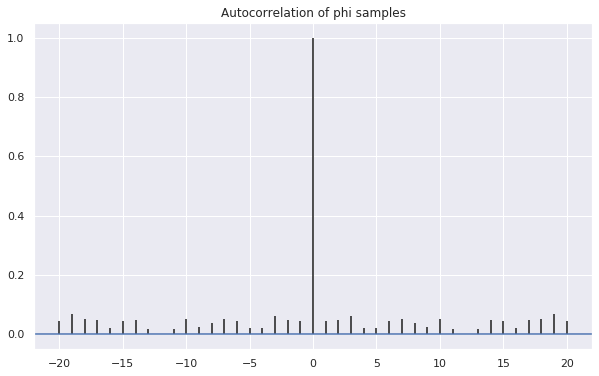

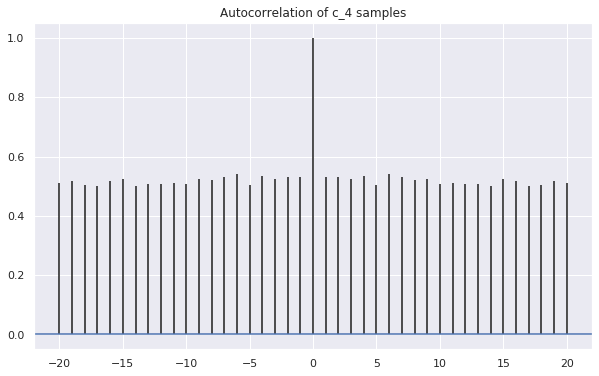

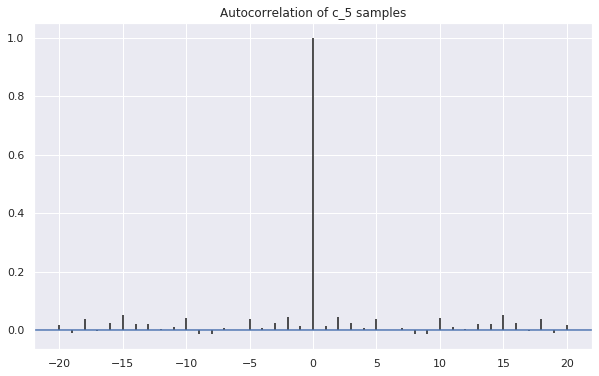

In [0]:
# plotting autocorrelation functions for the parameters of the quadratic model
def plot_acf(x): 
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    
    from scipy import signal 
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))
    
for p in parameters:
    plt.figure(figsize=(10,6)) 
    plot_acf(improved_samples[p]) 
    plt.title(f'Autocorrelation of {p} samples')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


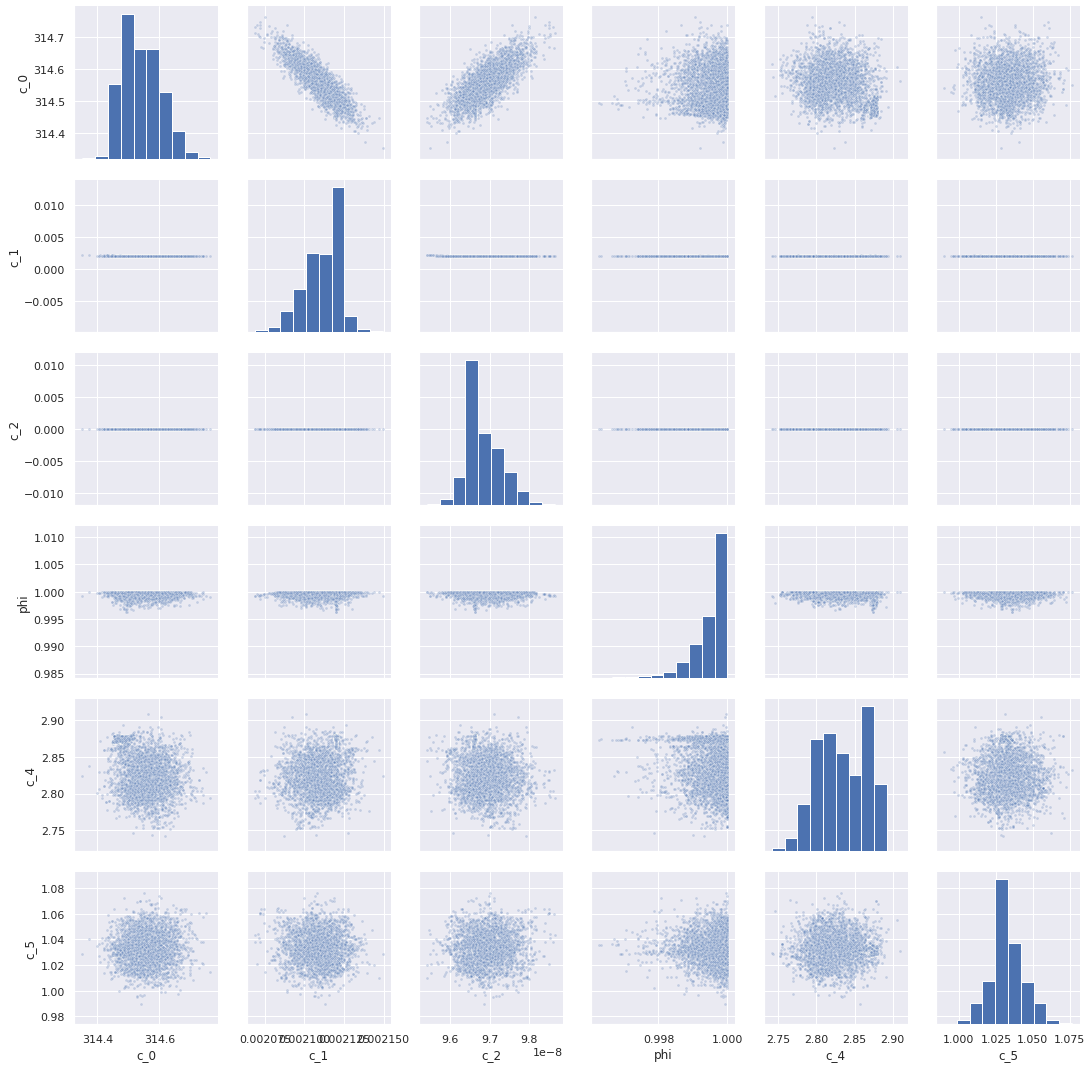

In [0]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([improved_samples[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [0]:
# organizing prediction samples 
prediction = improved_samples['CO2_pred']
# creating storage for mean prediction array 
mean_pred = []  
# creating the confidence intervals for the 
conf_prediction = np.percentile(prediction,axis=0,q=[2.5, 50.0, 97.5]) # upper 95% confidence interval

num_pred = 5219 # number of predictions 
record_today = 3139 # moment recording last took place 
# days_til_predict = time[0:record_today]
# days_future = time[record_today:5219]

for i in range(0,5219):
    mean_pred.append(np.mean(prediction[:,i]))

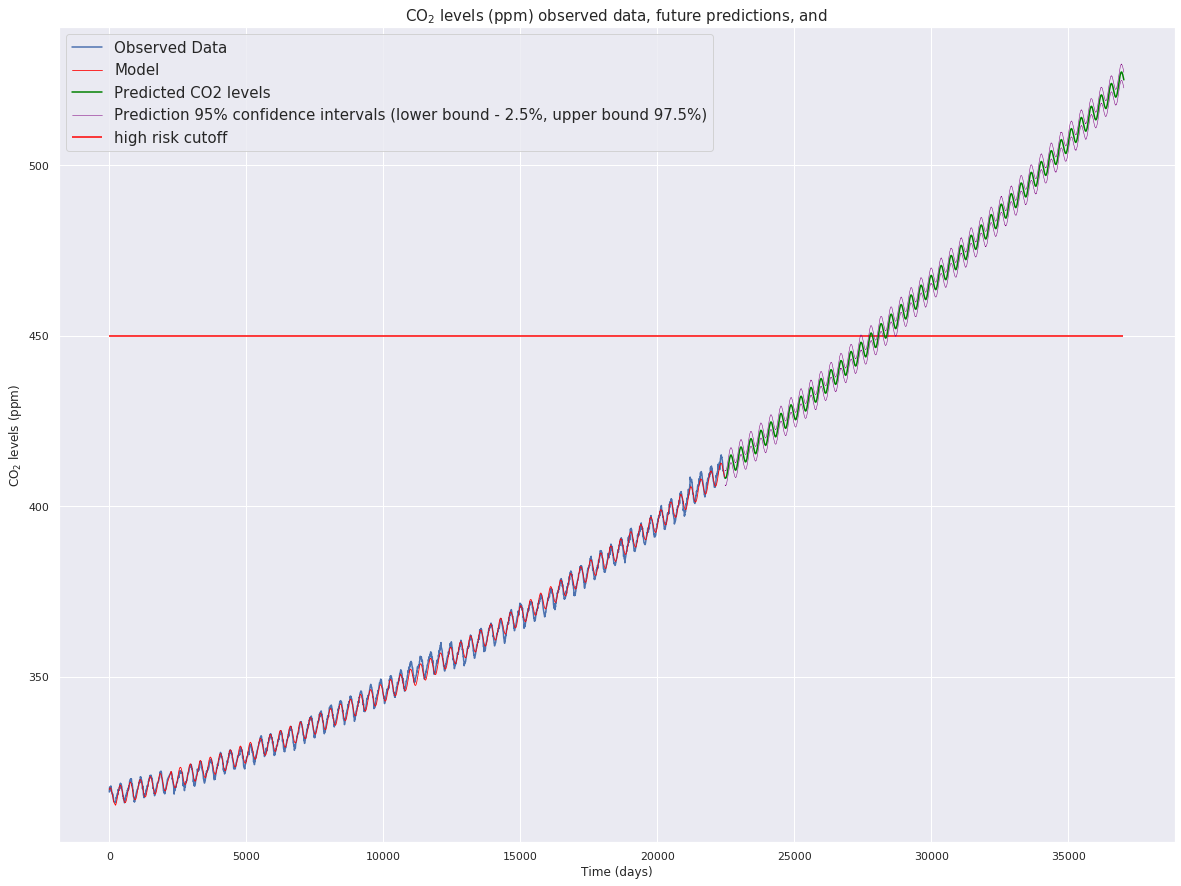

In [0]:
plt.figure(figsize = (20,15))

# observed data 
plt.plot(time[0:record_today], data['level'], label = 'Observed Data')

# model based on observed data 
plt.plot(time[0:record_today], mean_pred[0:record_today], color='red',label='Model',linewidth=0.8) 
# prediction 
plt.plot(time[record_today:num_pred], mean_pred[record_today:num_pred],color='green', label='Predicted CO2 levels')
# high-risk cutoff
plt.hlines(450, 0, 37000, color= 'red', label='high risk cutoff' ) 
#confidence intervals 
plt.plot(time[record_today:num_pred], conf_prediction[0][record_today:num_pred],'purple', linewidth=0.5,label='Prediction 95% confidence intervals (lower bound - 2.5%, upper bound 97.5%)')
plt.plot(time[record_today:num_pred], conf_prediction[2][record_today:num_pred],'purple',linewidth=0.5)

plt.xlabel('Time (days)')
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.legend(prop={'size': 15})
plt.title(r'CO$_2$ levels (ppm) observed data, future predictions, and ',fontsize=15)
plt.show()

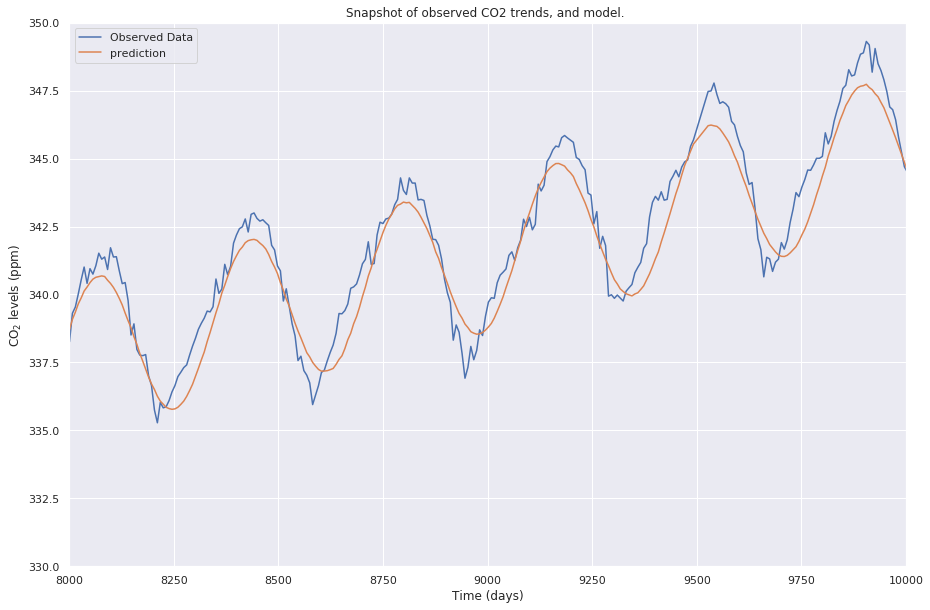

In [0]:
# plotting a snipet of data and model to understand the model fit  
plt.figure(figsize=(15,10))

# observed data 
plt.plot(time[0:record_today], data['level'], label = 'Observed Data')

# model fitted to the observed data 
plt.plot(time[0:num_pred],mean_pred[0:num_pred], label='prediction') 
plt.axis([8000,10000,330,350]) 

plt.ylabel(r'CO$_2$ levels (ppm)')
plt.xlabel('Time (days)')
plt.title('Snapshot of observed CO2 trends, and model. ')
plt.legend()
plt.show()


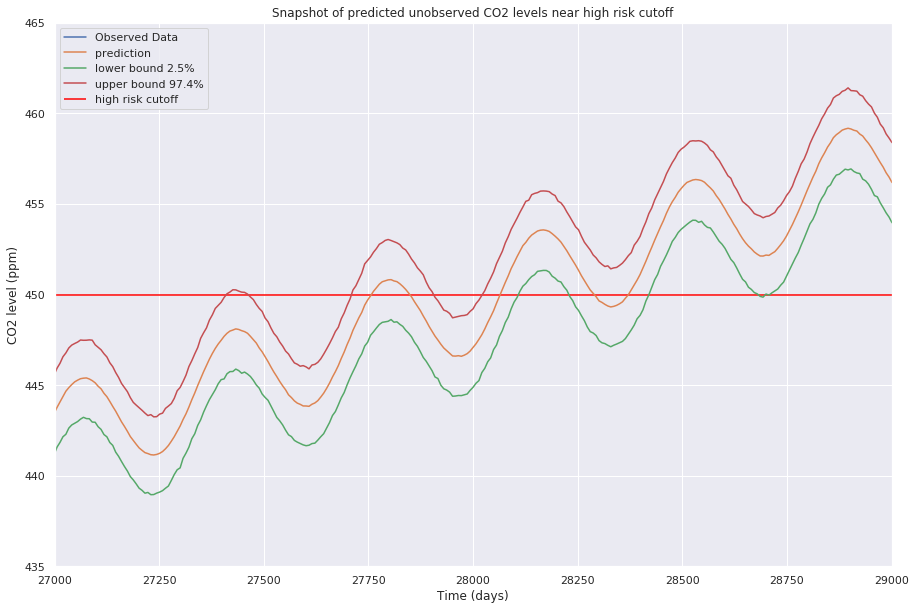

In [0]:
# plotting a snipet of prediction

plt.figure(figsize=(15,10))

# high-risk threshold
plt.hlines(450, 0, 37000, color= 'red', label='high risk cutoff' )

# observed data 
plt.plot(time[0:record_today], data['level'], label = 'Observed Data')

plt.plot(time[0:num_pred],mean_pred[0:num_pred], label='prediction') #predictions
plt.plot(time[record_today:num_pred],conf_prediction[0][record_today:num_pred], label = 'lower bound 2.5%') #lower conf.int.
plt.plot(time[record_today:num_pred],conf_prediction[2][record_today:num_pred], label = 'upper bound 97.4%') #upper conf.int
plt.axis([27000,29000,435,465]) 

plt.ylabel('CO2 level (ppm)')
plt.xlabel('Time (days)')
plt.title('Snapshot of predicted unobserved CO2 levels near high risk cutoff')
plt.legend()
plt.show()